In [16]:
# Step 1: Load Data & Calculate Annual Mean Temperatures (1990-2020)

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Step 1: Load Data & Calculate Annual Mean Temperatures (1990-2020)

ds = xr.open_dataset('air.mon.mean.nc') # loads in the air.mon.mean file
print(ds)

ds = ds.sel(time=slice('1990-01-01', '2020-12-31')) # selects the time period of 1990-2020

# calculate the global annual mean temperature (unweighted)
air_temp = ds['air']  # choose the air temperature column
air_temp_celsius = air_temp - 273.15  # convert from Kelvin to Celsius


weights = np.cos(np.deg2rad(ds['lat'])) # cosine latitude weights for the area 
weights.name = "weights"

# group by year first
air_temp_yearly = air_temp_celsius.groupby('time.year').mean(dim='time')

# calculate mean (unweighted) by grouping by year
annual_temp_unweighted = air_temp_yearly.mean(dim=['lat', 'lon'])

# calculate the mean (weighted) by grouping by year 
annual_temp_weighted = air_temp_yearly.weighted(weights).mean(dim=['lat', 'lon'])

# make new dataframe of the combined weight and unweighted annual mean tempertures 
annual_mean_temp_df = pd.DataFrame({
    'Year': air_temp_yearly['year'].values,
    'Unweighted_TA': annual_temp_unweighted.values,
    'Weighted_TA': annual_temp_weighted.values
})

print(annual_mean_temp_df.head())

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 926)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2025-02-01
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    title:          NOAA/NCEP GHCN CAMS Monthly Temperature
    Conventions:    CF-1.0
    Source:         http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/....
    version:        3.01
    history:        created 8/2012 by CAS NOAA/ESRL PSDupdated to include maj...
    dataset_title:  Climate Prediction Center (CPC) Global Land Surface Air T...
    References:     https://www.psl.noaa.gov/data/gridded/data.ghcncams.html
   Year  Unweighted_TA  Weighted_TA
0  1990       8.785168    13.697498
1  1991       8.714317    13.599257
2  1992       8.322989    13.296556
3  1993       8.499462    13.387334
4  1994       8

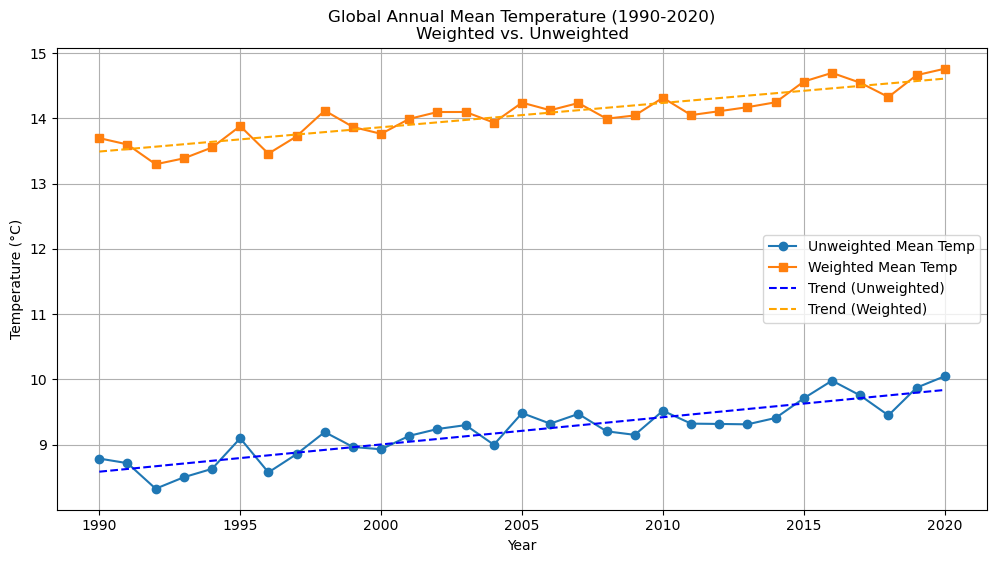

In [22]:
# Step 2: Time Series Visualization with Trends

plt.figure(figsize=(12, 6)) #creates the figure size dimensions and below lines are grabbing the right information from the newly made dataframe
plt.plot(annual_mean_temp_df['Year'], annual_mean_temp_df['Unweighted_TA'], label='Unweighted Mean Temp', marker='o')
plt.plot(annual_mean_temp_df['Year'], annual_mean_temp_df['Weighted_TA'], label='Weighted Mean Temp', marker='s')

# adds the linear regression trend lines
slope1, intercept1, _, _, _ = linregress(annual_mean_temp_df['Year'], annual_mean_temp_df['Unweighted_TA'])
slope2, intercept2, _, _, _ = linregress(annual_mean_temp_df['Year'], annual_mean_temp_df['Weighted_TA'])

# plots the weight and unweighted annual mean temps with newly made slopes
plt.plot(annual_mean_temp_df['Year'], slope1 * annual_mean_temp_df['Year'] + intercept1, linestyle='dashed', color='blue', label='Trend (Unweighted)')
plt.plot(annual_mean_temp_df['Year'], slope2 * annual_mean_temp_df['Year'] + intercept2, linestyle='dashed', color='orange', label='Trend (Weighted)')

# adds the labels and aesthetics to the plot
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Global Annual Mean Temperature (1990-2020)\nWeighted vs. Unweighted')
plt.legend()
plt.grid(True)
plt.show()

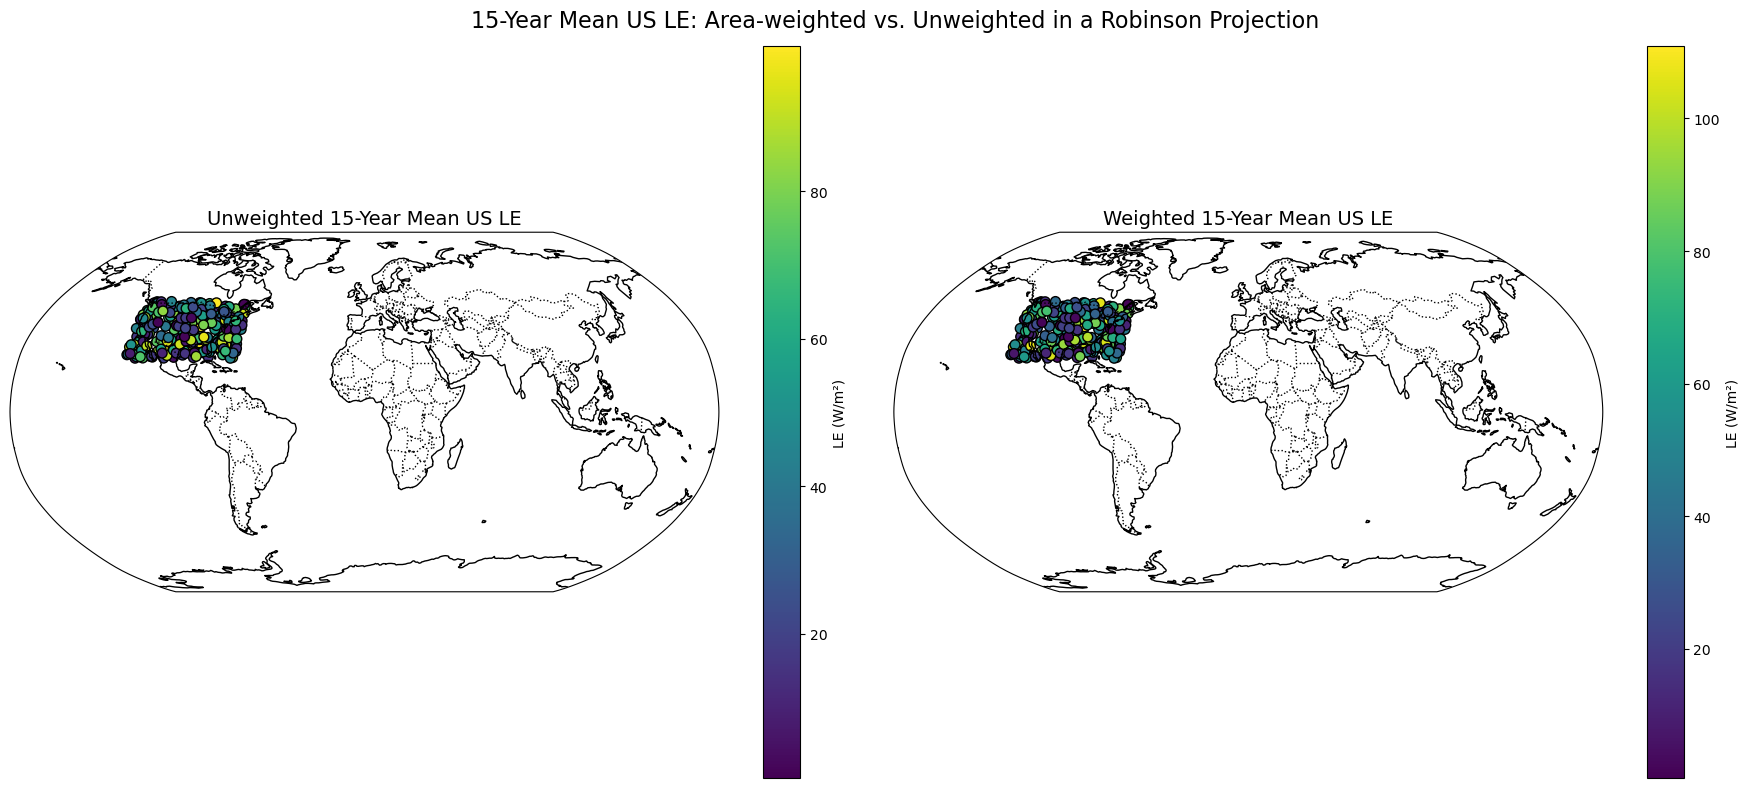

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Step 3: Map Visualization of 15-Year Mean US LE (Robinson Projection)

# must make a simulated LE data as placeholder 
np.random.seed(42)
num_points = 300
lats = np.random.uniform(24, 50, num_points)   # latitude range for US
lons = np.random.uniform(-125, -67, num_points)  # longitude range for US

# then generate random LE values to create a simulated "made-up" LE values 
LE_unweighted = np.random.uniform(0, 100, num_points)  # simulated unweighted LE values
LE_weighted = LE_unweighted * np.random.uniform(0.8, 1.2, num_points)  # simulated area-weighted LE

# plot in Robinson projection
fig, axs = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.Robinson()})

# first Panel: unweighted LE map
ax1 = axs[0]
sc1 = ax1.scatter(lons, lats, c=LE_unweighted, cmap='viridis', s=50, transform=ccrs.PlateCarree(), edgecolor='black')
ax1.set_title('Unweighted 15-Year Mean US LE', fontsize=14)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_global()
plt.colorbar(sc1, ax=ax1, orientation='vertical', label='LE (W/m²)')

# second panel: weighted LE map
ax2 = axs[1]
sc2 = ax2.scatter(lons, lats, c=LE_weighted, cmap='viridis', s=50, transform=ccrs.PlateCarree(), edgecolor='black')
ax2.set_title('Weighted 15-Year Mean US LE', fontsize=14)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_global()
plt.colorbar(sc2, ax=ax2, orientation='vertical', label='LE (W/m²)')

plt.suptitle('15-Year Mean US LE: Area-weighted vs. Unweighted in a Robinson Projection', fontsize=16)
plt.tight_layout()
plt.show()